In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from collections import defaultdict
from tqdm import tqdm
import random



In [4]:
#waves_s_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_s_ultralite.parquet'
waves_s_filepath = '/Users/sp624AA/Downloads/waves_light/WAVES-S_d1m3p1f1_light.parquet'
waves_n_filepath = '/Users/sp624AA/Downloads/waves_light/WAVES-N_d1m3p1f1_light.parquet'

In [5]:
star_gal = '/Users/sp624AA/Downloads/WAVES-N_d1m3p1f1_Z22_stargal.parquet'

In [18]:
read_columns = ['uberID', 'RAmax', 'Decmax', 'mask', 'starmask', 'ghostmask', 'class', 'duplicate', 'mag_Zt']
cat = pq.read_table(waves_n_filepath, columns=read_columns).to_pandas()
#cat.loc[cat['starmask'] == 1, 'class'] = 'star'
#cat = cat[(cat['duplicate']==0) & (cat['mask'] == 0) & (cat['starmask'] == 0)]
cat = cat#[(cat['duplicate']==0) & (cat['mask'] == 0) & (cat['starmask'] == 0) & (cat['ghostmask'] == 0)]

In [19]:
sg = pq.read_table(star_gal).to_pandas()

sg['uberID'] = sg['uberID'].astype(str)

In [14]:
cat.head()

uberID       RAmax    Decmax  mask  starmask  ghostmask   class  \
0  158000543107277  157.130797  0.523040   1.0       1.0        1.0  galaxy   
1  158000244406666  157.379716  0.472115   0.0       1.0        0.0    star   
2  158000041509376  157.548812  0.697926   0.0       1.0        0.0    star   
3  158000257707647  157.368637  0.553864   0.0       1.0        0.0    star   
4  158000257707653  157.368637  0.554364   0.0       1.0        0.0    star   

   duplicate  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [22]:
#inner merger on cat and sg on uberID
mix = cat.merge(sg, on='uberID', how='inner')




In [30]:
sum(cat['mag_Zt'] <= 22)

22896599

In [28]:
np.unique(mix['class'])

array(['ambiguous', 'artefact', 'galaxy', 'star'], dtype=object)

In [23]:
sg['ubse']

uberID   is_star      TYPE       R50     mag_rt    stargal
0  158000543107277  0.997400  0.847130  3.574439  17.800949     galaxy
1  158000244406666  0.691592  0.869220  0.678966  15.775480  ambiguous
2  158000041509376  0.922020  0.009856  1.332208  12.656421       star
3  158000257707647  0.000025  0.019080  2.341315  11.778070       star
4  158000257707653  0.852419  0.000838  2.405202  12.200885       star

In [ ]:
#cat = cat[(cat['duplicate']==0) & (cat['mask'] == 0) & (cat['starmask'] == 0) & (cat['ghostmask'])]

In [117]:
cat.head()

RAmax     Decmax  mask  starmask  ghostmask class  duplicate
0  359.763400 -26.658695   1.0       1.0        0.0  star        0.0
1    0.636508 -26.660723   1.0       1.0        0.0  star        0.0
2    0.169534 -27.442938   0.0       1.0        0.0  star        0.0
3    0.014079 -27.770772   0.0       1.0        1.0  star        1.0
4  359.998917 -27.719111   0.0       1.0        1.0  star        0.0

Processing data: 100%|██████████| 40883229/40883229 [03:13<00:00, 210815.51it/s]


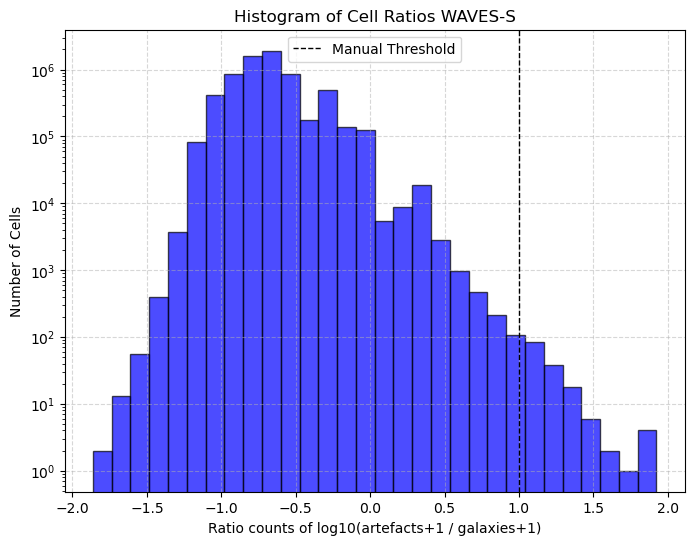

Using threshold: 10


Processing high-ratio cells: 100%|██████████| 181/181 [00:00<00:00, 186253.44it/s]


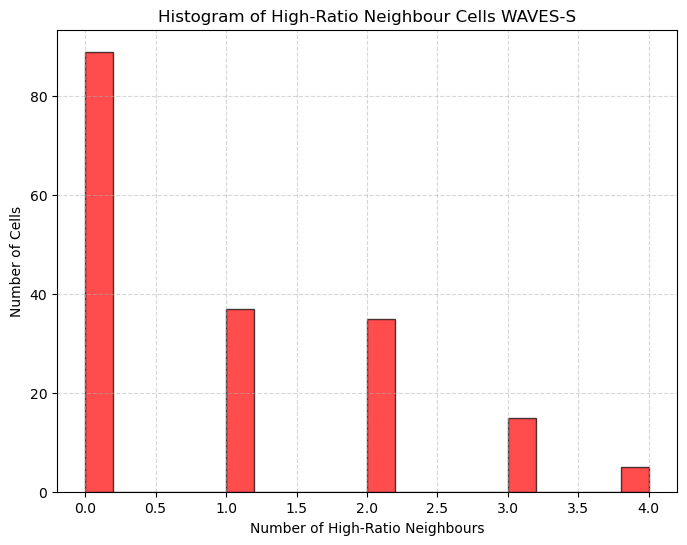

Using threshold: 10


Plotting cells: 100%|██████████| 55/55 [00:00<00:00, 2325.56it/s]


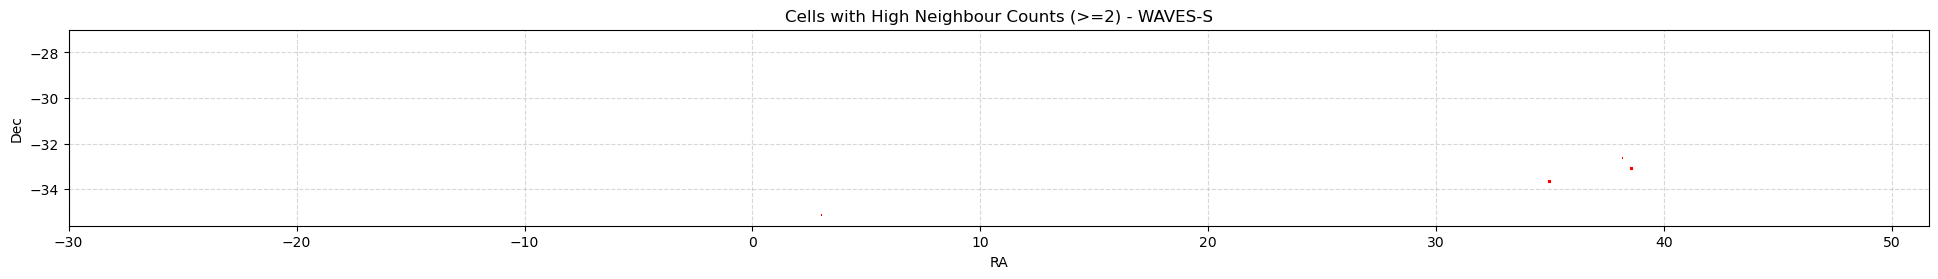

In [12]:
class Cell:
    def __init__(self, ra_index, dec_index):
        self.ra_index = ra_index
        self.dec_index = dec_index
        self.counts = defaultdict(int)

    def add_point(self, class_flag):
        self.counts[class_flag] += 1
    
    def get_ratio(self):
        artefacts = self.counts.get('artefact', 0)
        galaxies = self.counts.get('galaxy', 0)
        return (artefacts + 1) / (galaxies + 1)

class GridCounter:
    def __init__(self, cell_size=0.01, manual_threshold=10, name='WAVES-S', min_neighbour_threshold = 2):

        self.cell_size = cell_size
        self.manual_threshold = manual_threshold
        self.grid = {}
        self.name = name
        self.scale = int(1 / self.cell_size)  # Convert to integer scale
        self.min_neighbour_threshold = min_neighbour_threshold

    def _get_cell_key(self, ra, dec):
        ra_index = int(np.floor(ra * self.scale))
        dec_index = int(np.floor(dec * self.scale))
        return (ra_index, dec_index)
    
    def add_point(self, ra, dec, class_flag):
        cell_key = self._get_cell_key(ra, dec)
        if cell_key not in self.grid:
            self.grid[cell_key] = Cell(*cell_key)
        self.grid[cell_key].add_point(class_flag)
    
    def get_ratios(self):
        return {key: cell.get_ratio() for key, cell in self.grid.items()}
    
    def get_quantile_threshold(self, quantile=0.995):
        ratios = np.array(list(self.get_ratios().values()))
        return np.quantile(ratios, quantile) if ratios.size > 0 else None
    
    def get_high_ratio_neighbours(self, use_manual_threshold=True):
        ratios = self.get_ratios()
        
        threshold = self.manual_threshold if use_manual_threshold else self.get_quantile_threshold()
        print(f"Using threshold: {threshold}")
        
        if threshold is None:
            return {}
        
        high_ratio_cells = {key for key, ratio in ratios.items() if ratio >= threshold}
        neighbour_counts = {}
        
        for cell in tqdm(high_ratio_cells, desc="Processing high-ratio cells"):
            ra_idx, dec_idx = cell
            neighbours = [(ra_idx + dx, dec_idx + dy) 
                          for dx in [-1, 0, 1] 
                          for dy in [-1, 0, 1] 
                          if not (dx == 0 and dy == 0)]
            count = sum(n in high_ratio_cells for n in neighbours)
            neighbour_counts[cell] = count
        
        return neighbour_counts

    def plot_ratio_histogram(self, quantile=0.999):
        ratios = list(self.get_ratios().values())
        plt.figure(figsize=(8, 6))
        plt.hist(np.log10(ratios), bins=30, color='blue', alpha=0.7, edgecolor='black', log=True)
        plt.xlabel('Ratio counts of log10(artefacts+1 / galaxies+1)')
        plt.ylabel('Number of Cells')
        plt.title('Histogram of Cell Ratios ' +self.name)
        plt.grid(True, linestyle='--', alpha=0.5)
        
        #plt.axvline(np.log10(np.quantile(ratios, quantile)), color='r', linestyle='dashed', linewidth=1, label="Quantile Threshold")
        plt.axvline(np.log10(self.manual_threshold), color='k', linestyle='dashed', linewidth=1, label="Manual Threshold")
        plt.legend()
        plt.show()
    
    def plot_high_neighbour_histogram(self):
        neighbour_counts = self.get_high_ratio_neighbours()
        counts = list(neighbour_counts.values())

        plt.figure(figsize=(8, 6))
        plt.hist(counts, bins=20, color='red', alpha=0.7, edgecolor='black')
        plt.xlabel('Number of High-Ratio Neighbours')
        plt.ylabel('Number of Cells')
        plt.title('Histogram of High-Ratio Neighbour Cells ' +self.name)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
    
    def plot_high_neighbour_cells(self):
        neighbour_counts = self.get_high_ratio_neighbours()
        
        # Filter cells where count > 1
        filtered_cells = {cell: count for cell, count in neighbour_counts.items() if count >= self.min_neighbour_threshold}
        
        fig, ax = plt.subplots(figsize=(24, 8))
        
        for (ra, dec) in tqdm(filtered_cells.keys(), desc="Plotting cells"):
            ra = ra / self.scale
            dec = dec / self.scale
            rect = Rectangle((ra, dec), self.cell_size, self.cell_size, edgecolor='red', facecolor='none', linewidth=1.5)
            ax.add_patch(rect)
        
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.set_title(f'Cells with High Neighbour Counts (>={self.min_neighbour_threshold}) - {self.name}')
        
        # WAVES SOUTH
        if self.name == 'WAVES-S':
            ax.set_xlim([-30, 51.6])
            ax.set_ylim([-35.6, -27])
    
        # WAVES NORTH
        elif self.name == 'WAVES-N':
            ax.set_xlim([157.25, 225.0])
            ax.set_ylim([-3.95, 3.95])
        
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_aspect(1)
        plt.show()

    def plot_random_high_neighbour_cells(self, data, num_samples=5, plot_size=0.5):
        neighbour_counts = self.get_high_ratio_neighbours()
        grouped_cells = defaultdict(list)
        
        for cell, count in neighbour_counts.items():
            grouped_cells[count].append(cell)
        
        fig, axes = plt.subplots(len(grouped_cells), num_samples, figsize=(num_samples * 6, len(grouped_cells) * 6))
        if len(grouped_cells) == 1:
            axes = np.array([axes])
        
        class_colors = {'galaxy': 'blue', 'artefact': 'red', 'star': 'green', 'ambiguous': 'orange'}
        legend_patches = [Patch(color=color, label=class_flag) for class_flag, color in class_colors.items()]
        
        for i, (count, cells) in enumerate(grouped_cells.items()):
            sampled_cells = random.sample(cells, min(num_samples, len(cells)))
            
            for j, (ra, dec) in enumerate(sampled_cells):
                ra = ra / self.scale
                dec = dec / self.scale
                ax = axes[i, j] if len(grouped_cells) > 1 else axes[j]
                ra_center = ra + self.cell_size / 2
                dec_center = dec + self.cell_size / 2
                ra_min, ra_max = ra_center - plot_size / 2, ra_center + plot_size / 2
                dec_min, dec_max = dec_center - plot_size / 2, dec_center + plot_size / 2
                
                cell_data = data[(data['RAmax'] >= ra_min) & (data['RAmax'] <= ra_max) &
                                 (data['Decmax'] >= dec_min) & (data['Decmax'] <= dec_max)]
                
                for class_flag, color in class_colors.items():
                    subset = cell_data[cell_data['class'] == class_flag]
                    ax.scatter(subset['RAmax'], subset['Decmax'], color=color, alpha=0.5, s=0.25)
                
                rect = Rectangle((ra, dec), self.cell_size, self.cell_size, edgecolor='black', facecolor='none', linewidth=1.5)
                ax.add_patch(rect)
                
                ax.set_xlim(ra_min, ra_max)
                ax.set_ylim(dec_min, dec_max)
                ax.set_title(f'Neighbours: {count}')            
                ax.set_xlabel('RAmax')
                ax.set_ylabel('Decmax')
                
        fig.legend(handles=legend_patches, loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.show()




    def plot_all_high_neighbour_cells(self, data, plot_size=0.5):
        neighbour_counts = self.get_high_ratio_neighbours()
        class_colors = {'galaxy': 'blue', 'artefact': 'red', 'star': 'green', 'ambiguous': 'orange'}
        legend_patches = [Patch(color=color, label=class_flag) for class_flag, color in class_colors.items()]
        
        # Group cells by count
        count_groups = defaultdict(list)
        for cell, count in neighbour_counts.items():
            count_groups[count].append(cell)
        
        num_plots_per_file = 40  # 4 rows x 10 columns
    
        # Loop over each unique count value
        for count, cells in sorted(count_groups.items()):
            num_files = (len(cells) + num_plots_per_file - 1) // num_plots_per_file
            
            for file_idx in range(num_files):
                start_idx = file_idx * num_plots_per_file
                end_idx = min(start_idx + num_plots_per_file, len(cells))
                
                if start_idx >= end_idx:
                    continue  # Skip empty plots
                
                # Create a grid of subplots
                rows, cols = 10, 4
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
                axes = axes.flatten()  # Flatten for easy iteration
                
                for i, (ax, cell) in enumerate(zip(axes, cells[start_idx:end_idx])):
                    ra, dec = cell
                    ra = ra / self.scale
                    dec = dec / self.scale
                    ra_center = ra + self.cell_size / 2
                    dec_center = dec + self.cell_size / 2
                    ra_min, ra_max = ra_center - plot_size / 2, ra_center + plot_size / 2
                    dec_min, dec_max = dec_center - plot_size / 2, dec_center + plot_size / 2
                    
                    cell_data = data[(data['RAmax'] >= ra_min) & (data['RAmax'] <= ra_max) &
                                     (data['Decmax'] >= dec_min) & (data['Decmax'] <= dec_max)]
                    
                    for class_flag, color in class_colors.items():
                        subset = cell_data[cell_data['class'] == class_flag]
                        ax.scatter(subset['RAmax'], subset['Decmax'], color=color, alpha=0.25, s=0.1)
                    
                    rect = Rectangle((ra, dec), self.cell_size, self.cell_size, edgecolor='black', facecolor='none', linewidth=1.5)
                    ax.add_patch(rect)
                    
                    ax.set_xlim(ra_min, ra_max)
                    ax.set_ylim(dec_min, dec_max)
                    ax.set_title(f'Neighbours: {count}')
                    ax.set_xlabel('RAmax')
                    ax.set_ylabel('Decmax')
                
                # Hide unused subplots
                for j in range(i + 1, len(axes)):
                    axes[j].axis('off')
                
                # Add legend
                fig.legend(handles=legend_patches, loc='upper right', fontsize=12)
                plt.tight_layout()
                
                # Save figure (index based on count)
                plt.savefig(f'high_neighbour_cells_{count}_{file_idx + 1}_{self.name}.png')
                plt.close(fig)




grid_counter = GridCounter()
for ra, dec, class_flag in tqdm(zip(cat['RAmax'], cat['Decmax'], cat['class']), total=len(cat), desc="Processing data"):
    grid_counter.add_point(ra, dec, class_flag)

# Plot histograms
grid_counter.plot_ratio_histogram()
grid_counter.plot_high_neighbour_histogram()

# Plot high-neighbour cells
grid_counter.plot_high_neighbour_cells()
#grid_counter.plot_random_high_neighbour_cells()

Using threshold: 10


Processing high-ratio cells: 100%|██████████| 181/181 [00:00<00:00, 158622.86it/s]


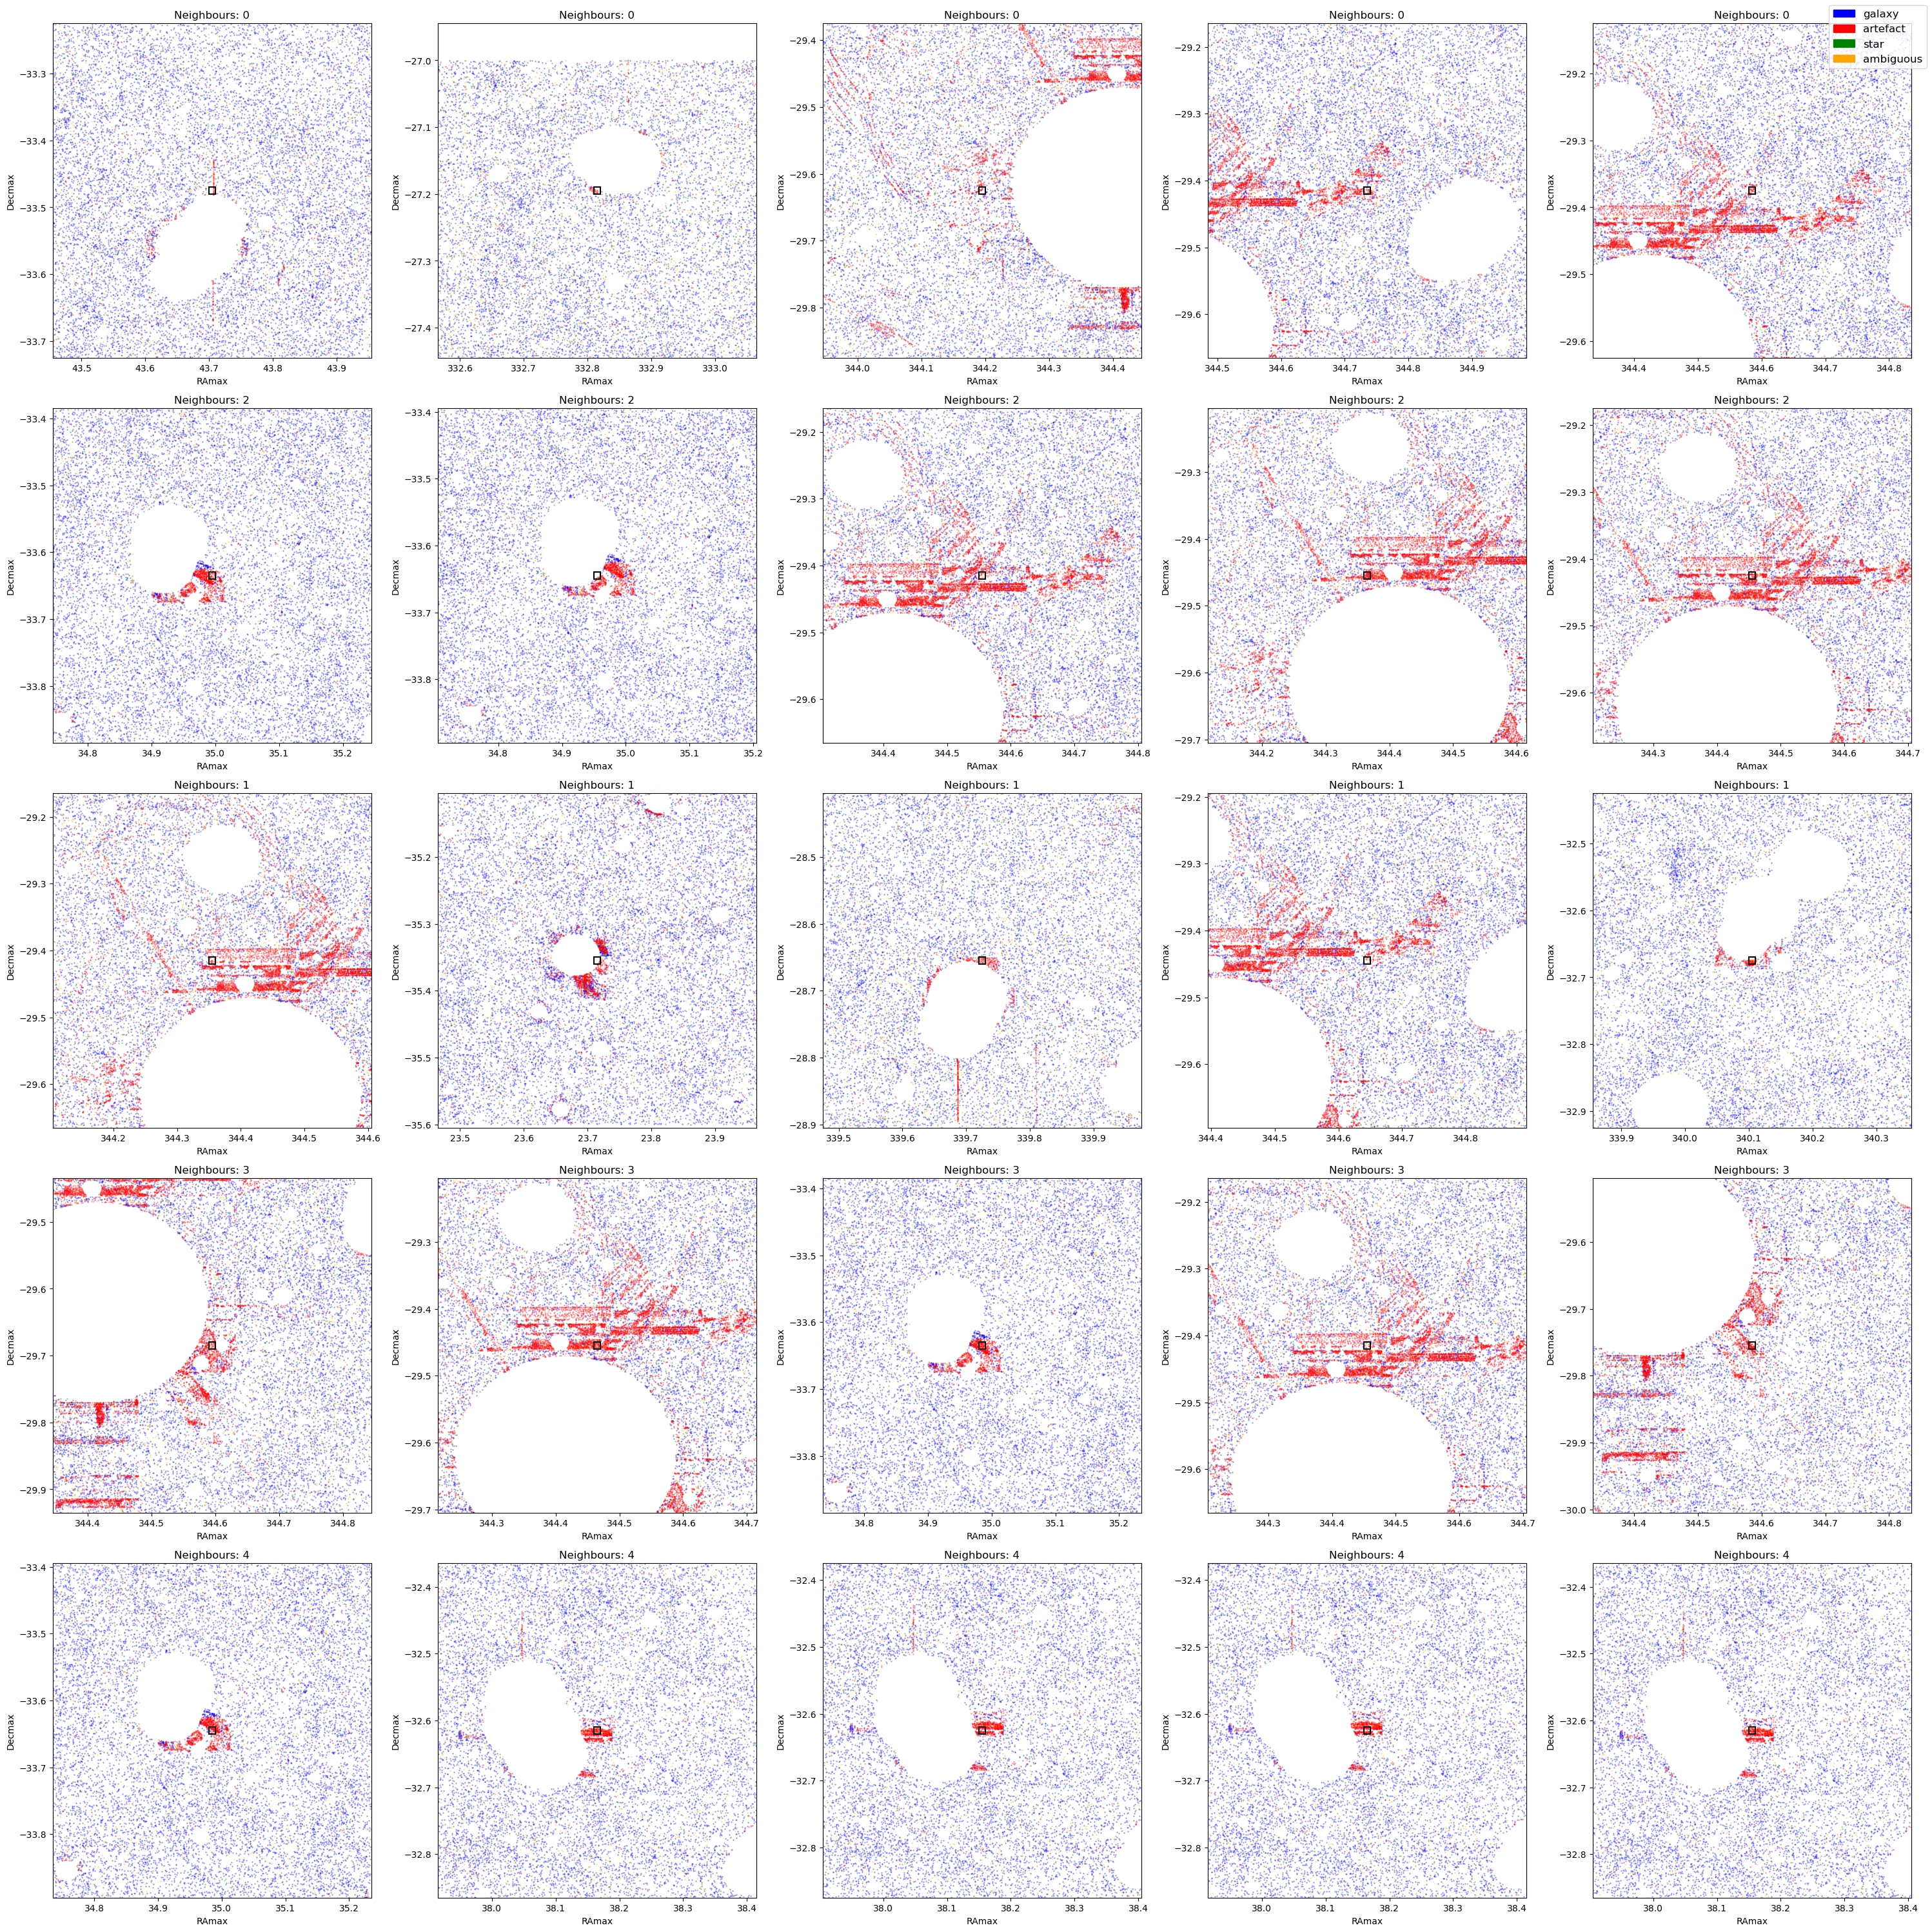

In [13]:
grid_counter.plot_random_high_neighbour_cells(cat)

In [14]:
grid_counter.plot_all_high_neighbour_cells(cat)

Using threshold: 10


Processing high-ratio cells: 100%|██████████| 181/181 [00:00<00:00, 165866.07it/s]


In [53]:
400 * 0.025**2

0.25000000000000006

Using threshold: 10


Plotting cells: 100%|██████████| 181/181 [00:00<00:00, 2737.61it/s]


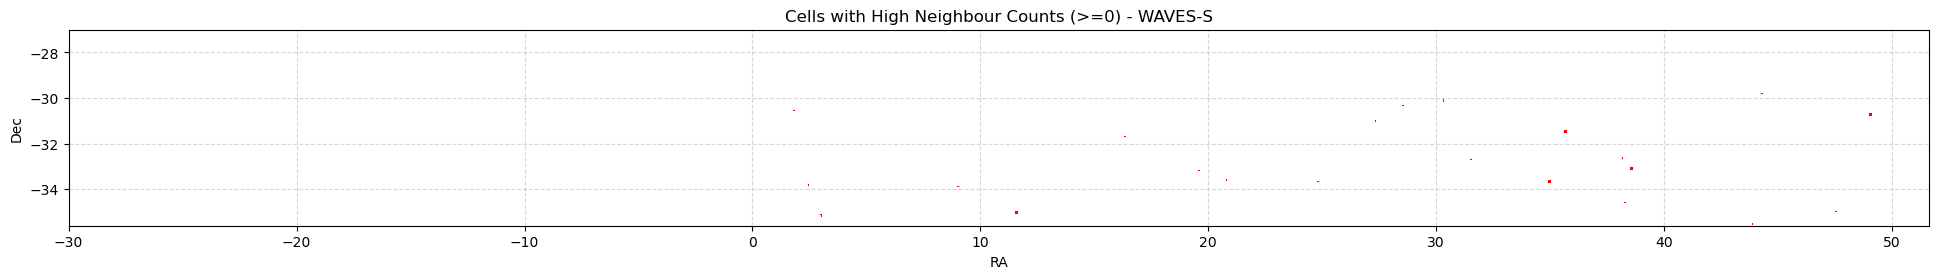

In [15]:
grid_counter.min_neighbour_threshold = 0 
grid_counter.plot_high_neighbour_cells()

In [98]:
big_star_sel = (cat['RAmax'] > 12.7) & (cat['RAmax'] < 12.9) & (cat['Decmax'] > -34.2) & (cat['Decmax'] < -34)
big_star_cat = cat[big_star_sel]

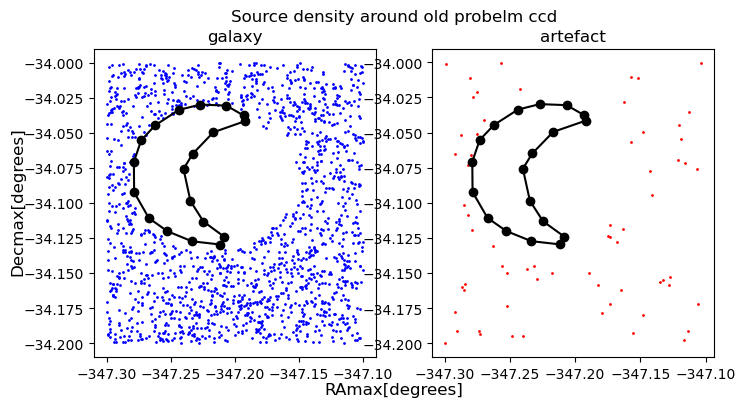

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 1 * 4))

# Given points
points = np.array([
    (12.8079466751452, -34.0415904616558),
    (12.7831777385283, -34.0495473349402),
    (12.7670770024823, -34.0649366696386),
    (12.7599021107783, -34.0757610555881),
    (12.7652825611636, -34.0986212005406),
    (12.7754591790667, -34.11327664894),
    (12.7915729794916, -34.124084445202),
    (12.7886075728582, -34.1296829907285),
    (12.7664628878019, -34.1273662408748),
    (12.7472632573874, -34.1201787884075),
    (12.7328423012578, -34.1108339952082),
    (12.7213439888796, -34.0923996826255),
    (12.7211274342094, -34.0707418456473),
    (12.7268365677775, -34.05528742605),
    (12.7376684338986, -34.0446640123143),
    (12.75618190299, -34.0336280189763),
    (12.7729558841024, -34.0297725459863),
    (12.7933640732484, -34.0305128015403),
    (12.8067077217364, -34.0375334091509)
])
points[:,0] = points[:,0] - 360
gal_arte = ['galaxy', 'artefact']
colours = ['b', 'r']

fig.suptitle('Source density around old probelm ccd')
for i in range(len(axes)):
    sub_sel_cat = big_star_cat[big_star_cat['class'] == gal_arte[i]]
    axes[i].scatter(sub_sel_cat['RAmax']-360, sub_sel_cat['Decmax'], s = 1, c = colours[i], alpha = 1)
    axes[i].set_title(gal_arte[i])




    # Extract x and y coordinates
    x_coords, y_coords = zip(*points)

    # Plotting
    #plt.figure(figsize=(10, 6))
    axes[i].plot(x_coords, y_coords, marker='o', linestyle='-', color='k')

# Adding arrows to indicate sequence
#for i in range(len(points) - 1):
 #   plt.arrow(x_coords[i], y_coords[i], x_coords[i+1] - x_coords[i], y_coords[i+1] - y_coords[i], 
 #             head_width=0.005, head_length=0.01, fc='r', ec='r')

# Adding labels and title

fig.supxlabel('RAmax[degrees]')
fig.supylabel('Decmax[degrees]')

fig.savefig('problem_ngc_waves_s')
# Show plot
plt.show()

In [118]:
big_star_sel = (cat['RAmax'] > 12.7) & (cat['RAmax'] < 12.85) & (cat['Decmax'] > -34.15) & (cat['Decmax'] < -34)
big_star_cat = cat[big_star_sel]

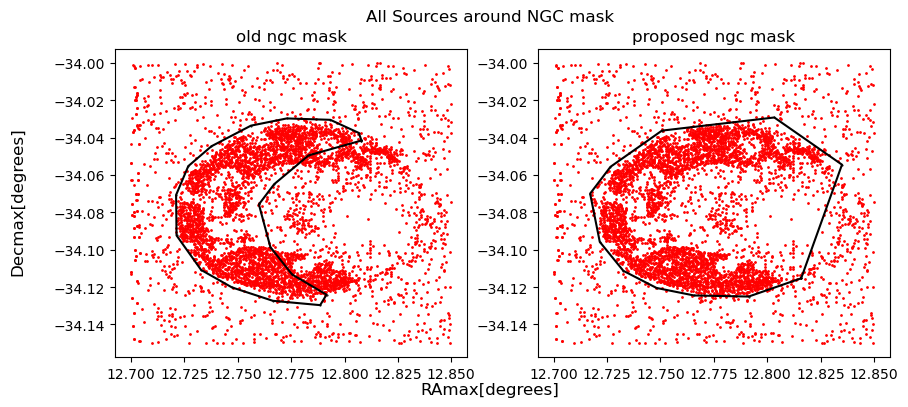

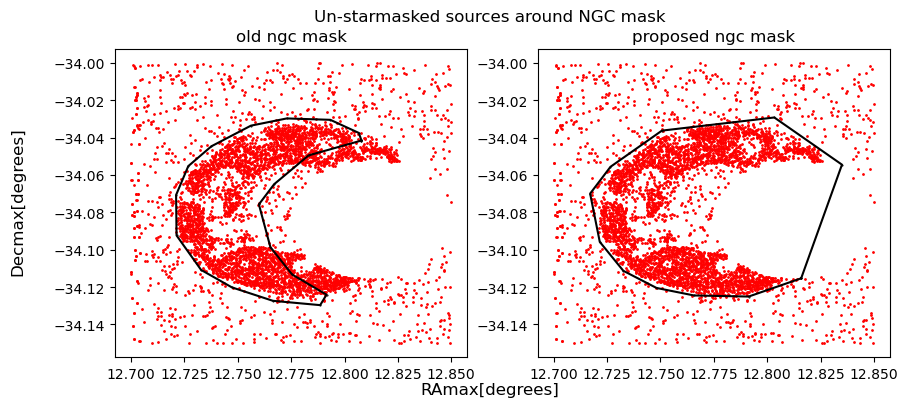

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 5, 1 * 4))

# Given points
points = np.array([
    [12.8079466751452, -34.0415904616558],
    [12.7831777385283, -34.0495473349402],
    [12.7670770024823, -34.0649366696386],
    [12.7599021107783, -34.0757610555881],
    [12.7652825611636, -34.0986212005406],
    [12.7754591790667, -34.11327664894],
    [12.7915729794916, -34.124084445202],
    [12.7886075728582, -34.1296829907285],
    [12.7664628878019, -34.1273662408748],
    [12.7472632573874, -34.1201787884075],
    [12.7328423012578, -34.1108339952082],
    [12.7213439888796, -34.0923996826255],
    [12.7211274342094, -34.0707418456473],
    [12.7268365677775, -34.05528742605],
    [12.7376684338986, -34.0446640123143],
    [12.75618190299, -34.0336280189763],
    [12.7729558841024, -34.0297725459863],
    [12.7933640732484, -34.0305128015403],
    [12.8067077217364, -34.0375334091509],#]
#    [12.8079466751452, -34.0415904616558],
])
#points = np.append(points, points[0])#- 360

new_points = np.array([
    [12.815886287625418, -34.11532786885246],
    [12.835, -34.054508196721315],
    [12.803311036789298, -34.02926229508197],
    [12.75066889632107, -34.036295081967216],
    [12.726588628762542, -34.05565573770492],
    [12.71705685618729, -34.07],
    [12.721571906354514, -34.09581967213115],
    [12.732608695652173, -34.111311475409835],
    [12.748160535117057, -34.12049180327869],
    [12.76571906354515, -34.124508196721315],
    [12.791304347826086, -34.12508196721311],]
#    [12.815886287625418, -34.11532786885246]
])


#new_points = np.append(new_points, new_points[0])#- 360
gal_arte = ['old ngc mask', 'proposed ngc mask']
#colours = ['b', 'r']

fig.suptitle('All Sources around NGC mask')
for i in range(len(axes)):
    sub_sel_cat = big_star_cat #[big_star_cat['class'] == gal_arte[i]]
    axes[i].scatter(sub_sel_cat['RAmax'], sub_sel_cat['Decmax'], s = 1, c = 'r', alpha = 1)
    axes[i].set_title(gal_arte[i])



    if i ==0:
        # Extract x and y coordinates
        x_coords, y_coords = points[:,0], points[:,1]
        # Plotting
        #plt.figure(figsize=(10, 6))
        axes[i].plot(x_coords, y_coords, marker='o', linestyle='-', color='k', ms = 0.5)
    if i ==1:
                # Extract x and y coordinates
        x_coords, y_coords = new_points[:,0], new_points[:,1]

        # Plotting
        #plt.figure(figsize=(10, 6))
        axes[i].plot(x_coords, y_coords, marker='o', linestyle='-', color='k', ms = 0.5)

# Adding arrows to indicate sequence
#for i in range(len(points) - 1):
 #   plt.arrow(x_coords[i], y_coords[i], x_coords[i+1] - x_coords[i], y_coords[i+1] - y_coords[i], 
 #             head_width=0.005, head_length=0.01, fc='r', ec='r')

# Adding labels and title

fig.supxlabel('RAmax[degrees]')
fig.supylabel('Decmax[degrees]')

fig.savefig('problem_ngc_waves_s_all')
# Show plot
plt.show()

fig.clf()
fig, axes = plt.subplots(1, 2, figsize=(2 * 5, 1 * 4))
fig.suptitle('Un-starmasked sources around NGC mask')
for i in range(len(axes)):
    sub_sel_cat = big_star_cat[big_star_cat['starmask'] == 0]
    axes[i].scatter(sub_sel_cat['RAmax'], sub_sel_cat['Decmax'], s = 1, c = 'r', alpha = 1)
    axes[i].set_title(gal_arte[i])



    if i ==0:
        # Extract x and y coordinates
        x_coords, y_coords = points[:,0], points[:,1]

        # Plotting
        #plt.figure(figsize=(10, 6))
        axes[i].plot(x_coords, y_coords, marker='o', linestyle='-', color='k', ms = 0.5)
    if i ==1:
                # Extract x and y coordinates
        x_coords, y_coords = new_points[:,0], new_points[:,1]

        # Plotting
        #plt.figure(figsize=(10, 6))
        axes[i].plot(x_coords, y_coords, marker='o', linestyle='-', color='k', ms = 0.5)

# Adding arrows to indicate sequence
#for i in range(len(points) - 1):
 #   plt.arrow(x_coords[i], y_coords[i], x_coords[i+1] - x_coords[i], y_coords[i+1] - y_coords[i], 
 #             head_width=0.005, head_length=0.01, fc='r', ec='r')

# Adding labels and title

fig.supxlabel('RAmax[degrees]')
fig.supylabel('Decmax[degrees]')

fig.savefig('problem_ngc_waves_s_unstarmasked')
# Show plot
plt.show()




In [165]:
points = np.array([
    [12.8079466751452, -34.0415904616558],
    [12.7831777385283, -34.0495473349402],
    [12.7670770024823, -34.0649366696386],
    [12.7599021107783, -34.0757610555881],
    [12.7652825611636, -34.0986212005406],
    [12.7754591790667, -34.11327664894],
    [12.7915729794916, -34.124084445202],
    [12.7886075728582, -34.1296829907285],
    [12.7664628878019, -34.1273662408748],
    [12.7472632573874, -34.1201787884075],
    [12.7328423012578, -34.1108339952082],
    [12.7213439888796, -34.0923996826255],
    [12.7211274342094, -34.0707418456473],
    [12.7268365677775, -34.05528742605],
    [12.7376684338986, -34.0446640123143],
    [12.75618190299, -34.0336280189763],
    [12.7729558841024, -34.0297725459863],
    [12.7933640732484, -34.0305128015403],
    [12.8067077217364, -34.0375334091509],
])
#points = np.append(points, [points[0]])

In [166]:
points[0]

array([ 12.80794668, -34.04159046])